In [ ]:
#install kaggle module
! pip install kaggle 

In [ ]:
#make directory kaggle
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#upload your json api and load it
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
# permission 600 gives the owner full read and write access to the file
! chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
#pull lung and colon images from kaggle
! kaggle datasets download andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.75G/1.76G [00:17<00:00, 62.1MB/s]
100% 1.76G/1.76G [00:17<00:00, 109MB/s] 


In [ ]:
#unzip folders
! unzip lung-and-colon-cancer-histopathological-images.zip 


Archive:  lung-and-colon-cancer-histopathological-images.zip
replace lung_colon_image_set/colon_image_sets/colon_aca/colonca1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#remove sample data
!rm -rf sample_data/ 

In [ ]:
#remove colon images folder
!rm -rf /content/lung_colon_image_set/lung_image_sets2/ 

In [ ]:
#import required modules
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
from skimage import data
from skimage.color import rgb2gray
import pickle

In [ ]:
#assign a string with lung image sets path
train_dir='/content/lung_colon_image_set/lung_image_sets' 

In [ ]:
#count images with jpeg in every folder with for loop. it will count each file with .jpeg extension
normal_imgs = [fn for fn in os.listdir(f'{train_dir}/lung_n') if fn.endswith('.jpeg')] 
aca_imgs = [fn for fn in os.listdir(f'{train_dir}/lung_aca') if fn.endswith('.jpeg')]
scc_imgs = [fn for fn in os.listdir(f'{train_dir}/lung_scc') if fn.endswith('.jpeg')]

In [ ]:
#randomly chooses 3 images from the directories
select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_aca = np.random.choice(aca_imgs, 3, replace = False)
select_scc = np.random.choice(scc_imgs, 3, replace = False)

In [ ]:
fig = plt.figure(figsize = (6,6)) # resizes over all figure size
for i in range(9):
    if i < 3: # print 3 different images, if number is decreased it will print the same image
        fp = f'{train_dir}/lung_n/{select_norm[i]}'
        label = 'NORMAL'
    elif 3<=i<6:
        fp = f'{train_dir}/lung_aca/{select_aca[i-3]}'
        label = 'ACA'
    elif 6<=i<=9:
        fp = f'{train_dir}/lung_scc/{select_scc[i-6]}'
        label = 'SCC'
    ax = fig.add_subplot(3, 3, i+1) # used to create a 3x3 figure, if numbers are changed it will give rescaling error
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100)) # image sizes in loading
    plt.imshow(fn, cmap='Greys_r') #  colormap
    plt.title(label) # gives title of each image
    plt.axis('off') # turn off axis because we will only show samples no need for axis x and y
plt.show()

In [ ]:
# number of each class is printed here
print("The number of normal lung images: ",len(normal_imgs)) 
print("The number of adenocarcinoma lung images: ",len(aca_imgs)) 
print("The number of squamous cell carcinoma lung images: ",len(scc_imgs)) 

In [ ]:
ACA1=plt.imread(train_dir+'/lung_aca/lungaca1.jpeg')
NORMAL1=plt.imread(train_dir+'/lung_n/lungn1.jpeg')
SCC1=plt.imread(train_dir+'/lung_scc/lungscc1.jpeg')
# shapes of each sample is given here 768x768 and 3 for RGB
print("Sizes and dimensions for lungaca1.jpeg: ",np.shape(ACA1))
print("Sizes and dimensions for lungnorm1.jpeg: ",np.shape(NORMAL1))
print("Sizes and dimensions for lungscc1.jpeg: ",np.shape(SCC1))

In [ ]:
!pip install split-folders                                      

In [ ]:
import splitfolders
# split folders by 70% for training, 20% for validation and 10% for testing
# seed is used for randomized operations
# disable group prefix not to allow distributing files equally
splitfolders.ratio(train_dir,output="lung_image_sets2",seed=42, ratio=(.7,.2,.1),group_prefix=None)



In [ ]:
# due to the fact that in setting up files in model training the flow from directory uses one folder for splitting
# move validation files to training folders
! find /content/lung_image_sets2/val/lung_aca/ -type f -print0 | xargs -0 mv -t /content/lung_image_sets2/train/lung_aca/
! find /content/lung_image_sets2/val/lung_scc/ -type f -print0 | xargs -0 mv -t /content/lung_image_sets2/train/lung_scc/
! find /content/lung_image_sets2/val/lung_n/ -type f -print0 | xargs -0 mv -t /content/lung_image_sets2/train/lung_n/

In [ ]:
# count jpeg files in train lung aca folder
len([fn for fn in os.listdir(f'/content/lung_image_sets2/train/lung_aca') if fn.endswith('.jpeg')])

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
ACA1=plt.imread('/content/lung_image_sets2/train/lung_aca/lungaca1.jpeg')

plt.figure()
plt.imshow(ACA1) 
plt.title('Original Sample ACA')
plt.show()

# convert to numpy array
data = img_to_array(ACA1) 
# expand dimension to one sample
samples = expand_dims(ACA1, 0)

# create image data augmentation generator
datagen = ImageDataGenerator(
        featurewise_center=True, # subtract the mean value of dataset from the image
        rotation_range=25, # rotates according to the range
        width_shift_range=0.15, # shifts image on width
        height_shift_range=0.15, # shifts image on height
        brightness_range=[0.3,1.3], # contrast change
        shear_range=0.1, # angle of slope effect 
        zoom_range=[0.6, 1.0], # zooming 
        horizontal_flip=True, # flips image horizontally
        vertical_flip=True, # flips image vertically
        channel_shift_range=90, # randomly shifts RGB channel
        fill_mode='reflect') # abcddcba|abcd|dcbaabcd when shifted fills the space with a reflection of the image

# create an iterator
it = datagen.flow(samples, batch_size=1)
fig, im = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(6):
    plt.subplot(330+1+i)
    chunk=it.next()
    sub_img=chunk[0].astype('uint8')
    plt.imshow(sub_img)
    plt.title('Possible outcome')
plt.show()

FileNotFoundError: ignored

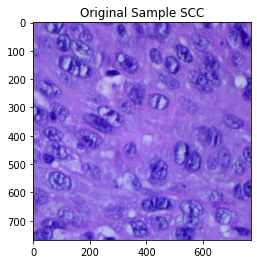

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


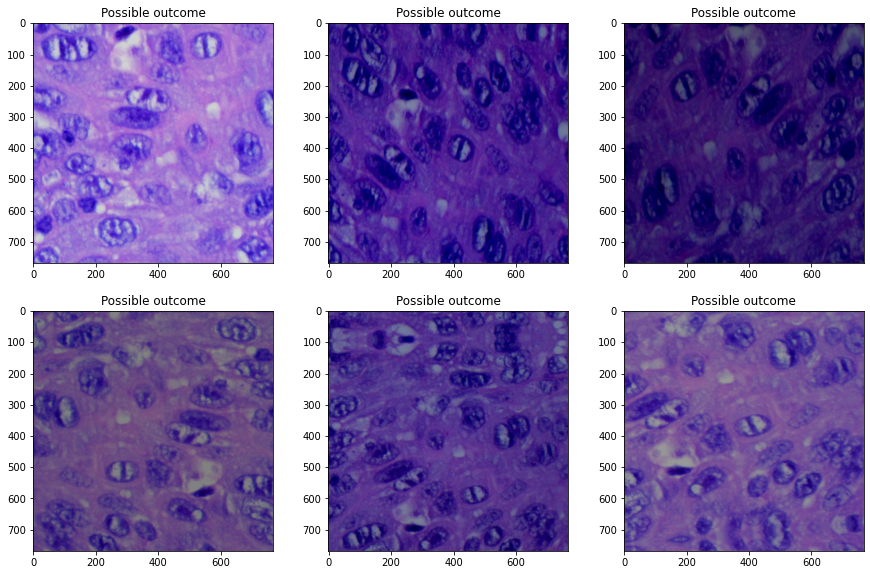

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
SCC1=plt.imread('/content/lung_image_sets2/train/lung_scc/lungscc1.jpeg')

plt.figure()
plt.imshow(SCC1) 
plt.title('Original Sample SCC')
plt.show()

# convert to numpy array
data = img_to_array(SCC1) 
# expand dimension to one sample
samples = expand_dims(SCC1, 0)

# create image data augmentation generator
datagen = ImageDataGenerator(
        featurewise_center=True, # subtract the mean value of dataset from the image
        rotation_range=25, # rotates according to the range
        width_shift_range=0.15, # shifts image on width
        height_shift_range=0.15, # shifts image on height
        brightness_range=[0.3,1.3], # contrast change
        shear_range=0.1, # angle of slope effect 
        zoom_range=[0.6, 1.0], # zooming 
        horizontal_flip=True, # flips image horizontally
        vertical_flip=True, # flips image vertically
        channel_shift_range=90, # randomly shifts RGB channel
        fill_mode='reflect') # abcddcba|abcd|dcbaabcd when shifted fills the space with a reflection of the image

# create an iterator
it = datagen.flow(samples, batch_size=1)
fig, im = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(6):
    plt.subplot(330+1+i)
    chunk=it.next()
    sub_img=chunk[0].astype('uint8')
    plt.imshow(sub_img)
    plt.title('Possible outcome')
plt.show()

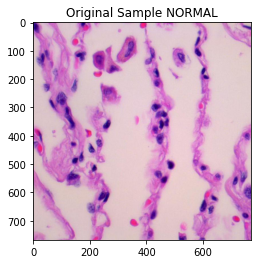

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


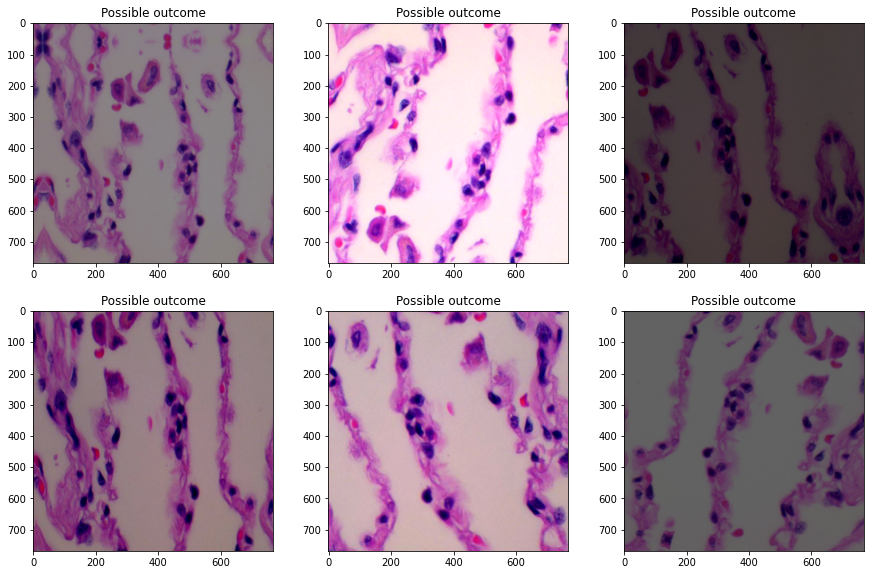

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
NORMAL1=plt.imread('/content/lung_image_sets2/train/lung_n/lungn1.jpeg')

plt.figure()
plt.imshow(NORMAL1) 
plt.title('Original Sample NORMAL')
plt.show()

# convert to numpy array
data = img_to_array(NORMAL1) 
# expand dimension to one sample, expands the shape of an array
samples = expand_dims(NORMAL1, 0)

# create image data augmentation generator
datagen = ImageDataGenerator(
        featurewise_center=True, # subtract the mean value of dataset from the image
        rotation_range=25, # rotates according to the range
        width_shift_range=0.15, # shifts image on width
        height_shift_range=0.15, # shifts image on height
        brightness_range=[0.3,1.3], # contrast change
        shear_range=0.1, # angle of slope effect 
        zoom_range=[0.6, 1.0], # zooming 
        horizontal_flip=True, # flips image horizontally
        vertical_flip=True, # flips image vertically
        channel_shift_range=90, # randomly shifts RGB channel
        fill_mode='reflect') # abcddcba|abcd|dcbaabcd when shifted fills the space with a reflection of the image

# create an iterator
it = datagen.flow(samples, batch_size=1)
fig, im = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of 6 images
for i in range(6):
    plt.subplot(330+1+i) # adds subplot to the current figure similar to add_subplot(3, 3, 0+1+i)
    chunk=it.next() #  fetches next item from the collection
    sub_img=chunk[0].astype('uint8') # cast pandas 8-bit unsigned integer object to a specified dtype
    plt.imshow(sub_img)
    plt.title('Possible outcome')
plt.show()

In [ ]:
#SCC AUGMENTATION
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        featurewise_center=True, # subtract the mean value of dataset from the image
        rotation_range=25, # rotates according to the range
        width_shift_range=0.15, # shifts image on width
        height_shift_range=0.15, # shifts image on height
        brightness_range=[0.3,1.3], # contrast change
        shear_range=0.1, # angle of slope effect 
        zoom_range=[0.6, 1.0], # zooming 
        horizontal_flip=True, # flips image horizontally
        vertical_flip=True, # flips image vertically
        channel_shift_range=90, # randomly shifts RGB channel
        fill_mode='reflect') # abcddcba|abcd|dcbaabcd when shifted fills the space with a reflection of the image

ct=1
#for ct in range(1,len([fn for fn in os.listdir(f'/content/lung_image_sets2/train/lung_scc') if fn.endswith('.jpeg')])):
for ct in range(1,500): # this loop generates images using data augmentation parameters with 500 images in the folder
    try:
      img = load_img('/content/lung_image_sets2/train/lung_scc/lungscc'+str(ct)+'.jpeg')  # this is a PIL image
    except:
      pass
    else:
      print("Generating new data with lungscc"+str(ct))
      x = img_to_array(img)  # this is a Numpy array with shape (3, 768, 768)
      x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 768, 768)
      i = 0
      for batch in datagen.flow(x, batch_size=1, save_to_dir='/content/lung_image_sets2/train/lung_scc/', save_prefix='lungscc', save_format='jpeg'):
        i += 1
        if i > 2:
          break  


Generating new data with lungscc1
Generating new data with lungscc2
Generating new data with lungscc3
Generating new data with lungscc4
Generating new data with lungscc5
Generating new data with lungscc6
Generating new data with lungscc7
Generating new data with lungscc8
Generating new data with lungscc9
Generating new data with lungscc10
Generating new data with lungscc11
Generating new data with lungscc12
Generating new data with lungscc13
Generating new data with lungscc14
Generating new data with lungscc16
Generating new data with lungscc17
Generating new data with lungscc18
Generating new data with lungscc19
Generating new data with lungscc20
Generating new data with lungscc21
Generating new data with lungscc22
Generating new data with lungscc23
Generating new data with lungscc24
Generating new data with lungscc26
Generating new data with lungscc27
Generating new data with lungscc28
Generating new data with lungscc29
Generating new data with lungscc30
Generating new data with lung

In [ ]:
#N AUGMENTATION
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        featurewise_center=True,
        rotation_range=25,
        width_shift_range=0.15,
        height_shift_range=0.15,
        brightness_range=[0.3,1.3],
        shear_range=0.1,
        zoom_range=[0.6, 1.0],
        horizontal_flip=True,
        vertical_flip=True,
        channel_shift_range=90,
        fill_mode='reflect')

ct=1

for ct in range(1,500):
    try:
      img = load_img('/content/lung_image_sets2/train/lung_n/lungn'+str(ct)+'.jpeg')  # this is a PIL image
    except:
      pass
    else:
      print("Generating new data with lungn"+str(ct))
      x = img_to_array(img)  # this is a Numpy array with shape (3, 768, 768)
      x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 768, 768)
      i = 0
      for batch in datagen.flow(x, batch_size=1, save_to_dir='/content/lung_image_sets2/train/lung_n/', save_prefix='lungn', save_format='jpeg'):
        i += 1
        if i > 2:
          break  


Generating new data with lungn1
Generating new data with lungn2
Generating new data with lungn3
Generating new data with lungn4
Generating new data with lungn5
Generating new data with lungn6
Generating new data with lungn7
Generating new data with lungn8
Generating new data with lungn9
Generating new data with lungn10
Generating new data with lungn11
Generating new data with lungn12
Generating new data with lungn13
Generating new data with lungn14
Generating new data with lungn16
Generating new data with lungn17
Generating new data with lungn18
Generating new data with lungn19
Generating new data with lungn20
Generating new data with lungn21
Generating new data with lungn22
Generating new data with lungn23
Generating new data with lungn24
Generating new data with lungn26
Generating new data with lungn27
Generating new data with lungn28
Generating new data with lungn29
Generating new data with lungn30
Generating new data with lungn32
Generating new data with lungn33
Generating new data

In [ ]:
#ACA AUGMENTATION
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        featurewise_center=True, # subtract the mean value of dataset from the image
        rotation_range=25, # rotates according to the range
        width_shift_range=0.15, # shifts image on width
        height_shift_range=0.15, # shifts image on height
        brightness_range=[0.3,1.3], # contrast change
        shear_range=0.1, # angle of slope effect 
        zoom_range=[0.6, 1.0], # zooming 
        horizontal_flip=True, # flips image horizontally
        vertical_flip=True, # flips image vertically
        channel_shift_range=90, # randomly shifts RGB channel
        fill_mode='reflect') # abcddcba|abcd|dcbaabcd when shifted fills the space with a reflection of the image, 
        #because nearest does not produce realistic images

ct=1

for ct in range(1,500): # this loop generates images using data augmentation parameters with 500 images in the folder
    try:
      img = load_img('/content/lung_image_sets2/train/lung_aca/lungaca'+str(ct)+'.jpeg')  # this is a PIL image
    except:
      pass
    else:
      print("Generating new data with lungaca"+str(ct))
      x = img_to_array(img)  # this is a Numpy array with shape (3, 768, 768)
      x = x.reshape((1,) + x.shape)  # this is a Numpy image array with shape (1, 3, 768, 768) 
      i = 0
      for batch in datagen.flow(x, batch_size=1, save_to_dir='/content/lung_image_sets2/train/lung_aca/', save_prefix='lungaca', save_format='jpeg'): # generated image is saved with lungaca.jpeg name
        i += 1
        if i > 2:
          break  


Generating new data with lungaca1
Generating new data with lungaca2
Generating new data with lungaca3
Generating new data with lungaca4
Generating new data with lungaca5
Generating new data with lungaca6
Generating new data with lungaca7
Generating new data with lungaca8
Generating new data with lungaca9
Generating new data with lungaca10
Generating new data with lungaca11
Generating new data with lungaca12
Generating new data with lungaca13
Generating new data with lungaca14
Generating new data with lungaca16
Generating new data with lungaca17
Generating new data with lungaca18
Generating new data with lungaca19
Generating new data with lungaca20
Generating new data with lungaca21
Generating new data with lungaca22
Generating new data with lungaca23
Generating new data with lungaca24
Generating new data with lungaca26
Generating new data with lungaca27
Generating new data with lungaca28
Generating new data with lungaca29
Generating new data with lungaca30
Generating new data with lung

In [ ]:
#create xception model
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception #this is the model that we used
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
IMAGE_SIZE = [150, 150]
#xception default target sizes 299,299

xcep = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=True)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
#enable training pre trained layers
for layer in xcep.layers:
    layer.trainable = True

In [ ]:
#print name scope of pre trained layers
for layer in xcep.layers:
    print(layer.name_scope)

<bound method Layer._name_scope of <keras.engine.input_layer.InputLayer object at 0x7f668f40d710>>
<bound method Layer._name_scope of <keras.layers.convolutional.Conv2D object at 0x7f6682f3dc10>>
<bound method Layer._name_scope of <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f6682f8b090>>
<bound method Layer._name_scope of <keras.layers.core.activation.Activation object at 0x7f6682f652d0>>
<bound method Layer._name_scope of <keras.layers.convolutional.Conv2D object at 0x7f6682f670d0>>
<bound method Layer._name_scope of <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f66804d9c10>>
<bound method Layer._name_scope of <keras.layers.core.activation.Activation object at 0x7f66804e0710>>
<bound method Layer._name_scope of <keras.layers.convolutional.SeparableConv2D object at 0x7f66804eaf10>>
<bound method Layer._name_scope of <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f66804d7e10>>
<bound m

In [ ]:
flatten = Flatten()(xcep.output)
dense = Dense(256, activation = 'relu')(flatten)
dense = Dense(128, activation = 'relu')(dense)
prediction = Dense(3, activation = 'softmax')(dense)

In [ ]:
#creating the model
model = Model(inputs = xcep.input, outputs = prediction , name = "Xception")

In [ ]:
import tensorflow as tf
train_setpath="/content/lung_image_sets2/train"
#test_setpath="/content/lung_image_sets2/test"
SIZE_X = SIZE_Y = 150 #default size 299 for Xception Model

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.25)

train_set = datagen.flow_from_directory(train_setpath,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       classes=None,
                                       batch_size = 64, 
                                       shuffle = True,
                                       subset='training',
                                       seed = 42)

test_set = datagen.flow_from_directory(train_setpath,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       classes=None,
                                       batch_size = 64, 
                                       shuffle = True,
                                       subset='validation',
                                       seed = 42)

Found 12943 images belonging to 3 classes.
Found 4314 images belonging to 3 classes.


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[keras.metrics.AUC(name='auc'),'acc'])
#bs = batch size = number of training examples utilized in one iteration

In [ ]:
history = model.fit(train_set, validation_data = (test_set), epochs = 20, verbose=1)

Epoch 1/20
203/203 [==============================] - 282s 1s/step - loss: 0.2218 - auc: 0.9892 - acc: 0.9421 - val_loss: 0.2869 - val_auc: 0.9833 - val_acc: 0.9400
Epoch 2/20
203/203 [==============================] - 262s 1s/step - loss: 0.0453 - auc: 0.9988 - acc: 0.9857 - val_loss: 0.0818 - val_auc: 0.9966 - val_acc: 0.9759
Epoch 3/20
203/203 [==============================] - 262s 1s/step - loss: 0.0239 - auc: 0.9996 - acc: 0.9919 - val_loss: 0.0199 - val_auc: 0.9997 - val_acc: 0.9928
Epoch 4/20
203/203 [==============================] - 261s 1s/step - loss: 0.0168 - auc: 0.9998 - acc: 0.9944 - val_loss: 0.0793 - val_auc: 0.9963 - val_acc: 0.9764
Epoch 5/20
203/203 [==============================] - 260s 1s/step - loss: 0.0641 - auc: 0.9980 - acc: 0.9819 - val_loss: 0.4218 - val_auc: 0.9840 - val_acc: 0.9729
Epoch 6/20
203/203 [==============================] - 263s 1s/step - loss: 0.0287 - auc: 0.9991 - acc: 0.9927 - val_loss: 0.0469 - val_auc: 0.9988 - val_acc: 0.9856
Epoch 7/20

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
xcep = Xception(weights='imagenet', include_top=True, input_shape=(299, 299, 3))
#Freezing all pretrained layers
for layer in xcep.layers[:]:
    layer.trainable = False
# Creating the model
model = Sequential()

# Adding the Xception convolutional base model
model.add(xcep)
# Adding new layers
flatten = Flatten()(xcep.output)
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='softmax'))
inputs = Input(shape=(299, 299, 3))
model.summary()

25591808/91884032 [=======>......................] - ETA: 0s

KeyboardInterrupt: ignored

In [ ]:
import seaborn as sns
test_labels = np.array(test_set.classes)
test_features=np.array(test_set)
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

weighted_results = model.evaluate(test_features, test_labels,
                                           batch_size=256, verbose=1)
for name, value in zip(model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, model.predict(test_features, batch_size=256))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

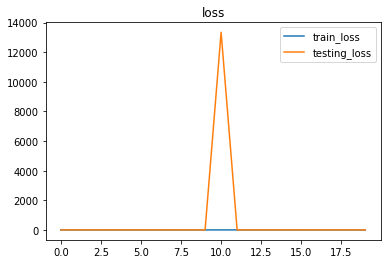

In [ ]:
# plotting the loss
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()


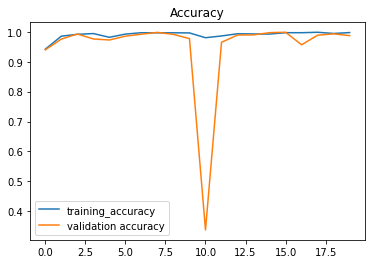

In [ ]:


# Both Validation and Training accuracy is shown here

plt.plot(history.history['acc'], label='training_accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()



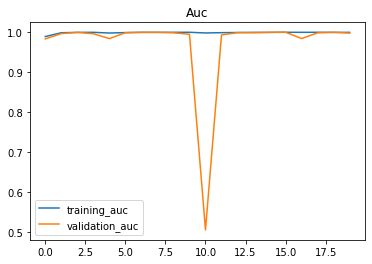

In [ ]:
plt.plot(history.history['auc'], label='training_auc')
plt.plot(history.history['val_auc'], label='validation_auc')
plt.title('Auc')
plt.legend()
plt.show()

In [ ]:
# CHECKING THE CONFUSION MATRIX

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred ,axis =1)
print('Confusion Matrix')
confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print(confusion_matrix)
print('Classification Report')
target_names = ['aca','n', 'scc']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Confusion Matrix
[[956   0  44]
 [601 399   0]
 [353   0 647]]
Classification Report
              precision    recall  f1-score   support

         aca       0.50      0.96      0.66      1000
           n       1.00      0.40      0.57      1000
         scc       0.94      0.65      0.77      1000

    accuracy                           0.67      3000
   macro avg       0.81      0.67      0.66      3000
weighted avg       0.81      0.67      0.66      3000



In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.999999)
test_setpath="/content/lung_image_sets2/test"
val_set = datagen.flow_from_directory(test_setpath,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128, 
                                       shuffle = True,
                                       subset='validation',
                                       seed = 42)
result = model.evaluate(val_set,batch_size=128)
print("test_loss, test accuracy",result)


Found 1497 images belonging to 3 classes.
12/12 [==============================] - 19s 1s/step - loss: 0.0781 - auc: 0.9969 - acc: 0.9873
test_loss, test accuracy [0.07814739644527435, 0.99687659740448, 0.9873079657554626]


In [ ]:
model.save('lung_cancer_diagnosis_model')

In [ ]:
! ls /content/

sample_data


In [ ]:
import tensorflow as tf
import os

graph_def = tf.compat.v1.GraphDef()
labels = []

# These are set to the default names from exported models, update as needed.
filename = '/content/gdrive/MyDrive/srproj/saved_model/saved_model.pb'

model = tf.keras.models.load_model('/content/gdrive/MyDrive/srproj/saved_model/')
model.summary()

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import tensorflow as tf
import os

graph_def = tf.compat.v1.GraphDef()
labels = []

# These are set to the default names from exported models, update as needed.


model = tf.keras.models.load_model('/content/gdrive/MyDrive/srproj/saved_model/')
model.summary()

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from PIL import Image
import cv2
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import decimal
labels=['aca','n','scc']
corrlist=[]
def getmyarray(list1):
  for sublist in list1:
    for i in sublist:
      corrlist.append(i)
  return corrlist

def getpredres(arr): 
  max=arr[0]
  ct=0
  for x in arr:
    if(x>max):
      max=x
  for a in arr:
    ct+=1
    if(a==max):
      break   
  return labels[ct-1]
  
def getprediction(imgp):
  img = image.load_img(imgp, target_size = (150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  tflite_model_file = '/content/model.tflite'
  with open(tflite_model_file, 'rb') as fid:
        tflite_model = fid.read()
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  prediction = []
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  prediction.append(interpreter.get_tensor(output_index))
  predicted_label = np.argmax(prediction)
  print(m)
  return labels[predicted_label]
getprediction("/content/gdrive/MyDrive/lungaca5000.jpeg")

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


'aca'

In [ ]:
from PIL import Image
import cv2
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
labels=['aca','n','scc']
corrlist=[]
def getmyarray(list1):
  for sublist in list1:
    for i in sublist:
      corrlist.append(i)
  return corrlist

def getpredres(arr): 
  max=arr[0]
  ct=0
  for x in arr:
    if(x>max):
      max=x
  for a in arr:
    ct+=1
    if(a==max):
      break   
  return labels[ct-1]
def getprediction():
  model = tf.keras.models.load_model('/content/gdrive/MyDrive/srproj/saved_model/')
  img = image.load_img("/content/gdrive/MyDrive/lungn5000.jpeg", target_size = (150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  arr=model.predict(img)
  c=[]
  c=getmyarray(arr)
  getpredres(c)

In [ ]:
from flask import Flask, render_template, request
from keras.models import load_model
from keras.models import Model
from keras.preprocessing import image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras
from pathlib import Path
from tensorflow.python.platform import gfile
from PIL import Image
import cv2
from PIL import Image

app = Flask(__name__)
app.debug=True
p = {}
labels=['aca','n','scc']
corrlist=[]

# functions

def getmyarray(list1):
  for sublist in list1:
    for i in sublist:
      corrlist.append(i)
  return corrlist

def getpredres(arr): 
  max=arr[0]
  ct=0
  for x in arr:
    if(x>max):
      max=x
  for a in arr:
    ct+=1
    if(a==max):
      break   
  return labels[ct-1]

def load_image(img_path):

    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    return img_tensor


# routes

@app.route('/', methods=['GET', 'POST'])
def main():
    return render_template('/content/gdrive/MyDrive/new.html')


@app.route('/submit', methods=['GET', 'POST'])
def predict():
    if request.method == 'POST':
        img = request.files['my_image']
        img_path = 'static/' + img.filename
        img.save(img_path)
    model = tf.keras.models.load_model('/content/gdrive/MyDrive/srproj/saved_model/')
    img = image.load_img(img_path, target_size = (150, 150))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    arr=model.predict(img)
    c=[]
    c=getmyarray(arr)
    getpredres(c)
    p = getpredres(c)
    return render_template('/content/gdrive/MyDrive/new.html', prediction = p, img_path=img_path)

if __name__ == "_main_":
  app.run(host='0.0.0.0', port=30006, debug=True)

gdrive	sample_data


In [ ]:
! pip install flask_ngrok

In [ ]:
from google.colab.output import eval_js
eval_js("google.colab.kernel.proxyPort(30006)")

KeyboardInterrupt: ignored

In [ ]:
from flask import Flask, render_template, request
from keras.models import load_model
from keras.models import Model
from keras.preprocessing import image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras
from pathlib import Path
from PIL import Image

app = Flask(__name__, template_folder="templates", static_folder="static")
app.debug=True
p = {}
labels=['Adenocarcinoma','Normal','Squamous Cell Carcinoma']
corrlist=[]

# functions

def getmyarray(list1):
  for sublist in list1:
    for i in sublist:
      corrlist.append(i)
  return corrlist

def getpredres(arr): 
  max=arr[0]
  ct=0
  for x in arr:
    if(x>max):
      max=x
  for a in arr:
    ct+=1
    if(a==max):
      break   
  return labels[ct-1]

# imshow expects values in the range [0, 1] img_tensor /= 255. 



# routes

@app.route('/', methods=['GET', 'POST'])
def main():
    return render_template('new.html')


@app.route('/submit', methods=['GET', 'POST'])
def predict():
    if request.method == 'POST':
        img = request.files['my_image']
        img_path = 'static/' + img.filename
        img.save(img_path)
    model = tf.keras.models.load_model('C:/Users/nigbu/seniorproj/saved_model')
    img = image.load_img(img_path, target_size = (150, 150))
    img = image.img_to_array(img)  # (height, width, channels)
    img = np.expand_dims(img, axis = 0) # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    arr=model.predict(img)
    c=[]
    c=getmyarray(arr)
    getpredres(c)
    p = getpredres(c)
    return render_template('new.html', prediction = p, img_path=img_path)

if __name__ == "_main_":
  app.run(host='0.0.0.0', port=30006, debug=True)